In [9]:
from openseespy.opensees import *
import numpy as np
import os
import matplotlib.pyplot as plt  
%matplotlib inline
import PIL
import openseespy.postprocessing.Get_Rendering as opp
import pandas as pd
import time

In [10]:
def scattermodelplotter(nodes):
    fig=plt.figure(figsize=[10,7])
    ax=plt.axes(projection="3d")
    
    for node in nodes:
      ax.scatter3D(*node,color='green')
    plt.title("Model node location")
    plt.grid()
    plt.show()


In [11]:
wipe()
model("basic",'-ndm',3,'-ndf',6)
bayx=6.0
bayy=7.0
storey=3.5

#gridlines
x0=0.0
x1=6.0

y0=0.0
y1=7.0

z0=0.0
z1=3.5

#define nodes
na0=[x0,y0,z0]   #A
na1=[x0,y0,z1]

nb0=[x1,y0,z0]   #B
nb1=[x1,y0,z1]

nc0=[x0,y1,z0]   #C
nc1=[x0,y1,z1]

nd0=[x1,y1,z0]   #D
nd1=[x1,y1,z1]

nodes=[na0,na1,nb0,nb1,nc0,nc1,nd0,nd1]

for x,y in enumerate(nodes):
    node(x+1,*y)
# printModel("-node")
# scattermodelplotter(nodes)

###naming the node tags
na0=1
na1=2

nb0=3
nb1=4

nc0=5
nc1=6

nd0=7
nd1=8

fixpattern=[1]*6
fix(na0,*fixpattern)
fix(nb0,*fixpattern)
fix(nc0,*fixpattern)
fix(nd0,*fixpattern)


No Model_ODB specified, trying to get data from the active model.
3D model


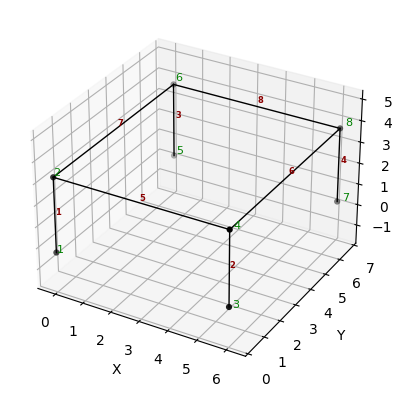

No Model_ODB specified to plot modeshapes
3D model


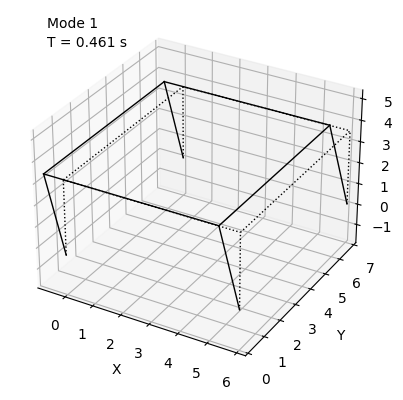

No Model_ODB specified to plot modeshapes
3D model


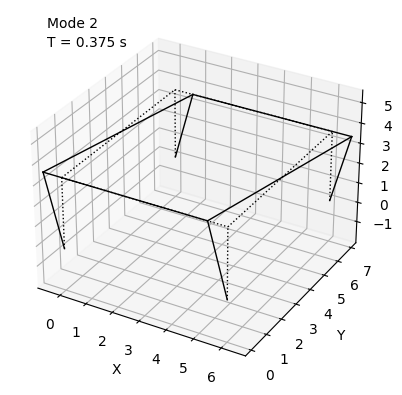

No Model_ODB specified to plot modeshapes
3D model


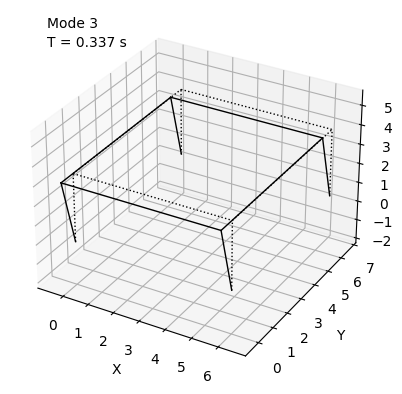

In [12]:
#define materials

#setting id of materials
C_concrete=1
unconfined_concrete=2
Rebar_steel=3

#parameters for models

fc1=-25000    #unconfined
fc2=-28000    #confined
epsc=-0.002   #strain at maximum stress in compression
fu1= 0.2*fc1  #ultimate for unconfined
fu2= 0.2*fc2  #ultimate for confined
epsu=-0.02    #strain at ultimate stress in comparison
lamba=0.1     #ratio between reloading stiffness and initial stiffness in compression
ft1=-0.1*fc1  #maximum stress in tension for unconfined concrete
ft2=-0.1*fc2  #maximum stress in tension for confined concrete
et1=ft1/0.002 #Elastic modulus in tension for unconfined concrete 
et2=ft2/0.002 #Elastic modulus in tension for confined concrete

# E in compression is calculated automatically depending on other material properties

fy=420000     #for reinforcing steel
Es=210000000; #E for reinforcing steel
b=0.005;      #strain hardening ratio
R0=20;        #smoothness of the elastic-to-plastic transition
cR1=0.925;    #smoothness of the elastic-to-plastic transition	
cR2=0.15;     #smoothness of the elastic-to-plastic transition  

#define concrete material
#uniaxialMaterial('Concrete02', matTag, fpc, epsc0, fpcu, epsU, lambda, ft, Ets)
uniaxialMaterial("Concrete02",C_concrete,fc1,epsc,fu1,epsu,lamba,ft1,et1)
uniaxialMaterial("Concrete02",unconfined_concrete,fc2,epsc,fu2,epsu,lamba,ft2,et2)

#define steel
#uniaxialMaterial('Steel02', matTag, Fy, E0, b, *params, a1=a2*Fy/E0, a2=1.0, a3=a4*Fy/E0, a4=1.0, sigInit=0.0)
uniaxialMaterial("Steel02",Rebar_steel,fy,Es,b,R0,cR1,cR2)

#define sections IDs
c300x400=1
b300x600=2

#Define dimensions                   
pi= np.pi          
Rebar_25=pi*0.025*0.025/4;  #area rebar 25mm
b_col=0.3; #column base
h_col=0.4; #column height
r_col=0.04; #column cover
b_beam=0.3; #beam base      
h_beam=0.6; #beam height
r_beam=0.04; #beam cover

def fibercreator(secID,Hsec,Bsec,
                 Confined_concrete,unconfined_concrete,Rebar_steel,
                 ch,cb,
                 ntop,areatop,nbot,areabot,ninterTotal,areainter,
                 nfcorey,nfcorez,nfcovy,nfcovz):
    
    coverY=Hsec/2.0
    coverZ=Bsec/2.0
    coreY=coverY-ch
    coreZ=coverZ-cb
    numBarsInt=int(ninterTotal/2)  #no. of intermediate bars per side 

    #    define fiber sections
    section("Fiber",secID,'-GJ',1000000000)
    
    #    define the core
    patch("quad",Confined_concrete,nfcorey,nfcorez,-coreY,coreZ,-coreY,-coreZ,coreY,-coreZ,coreY,coreZ)

    #    define the four cover patches
    patch("quad",unconfined_concrete,2,nfcovy,-coverY,coverZ,-coreY,-coreZ,coreY,coreZ,coverY,coverZ)
    patch("quad",unconfined_concrete,2,nfcovy,-coreY,-coreZ,-coverY,-coverZ,coverY,-coverZ,coreY,-coreZ)
    patch("quad",unconfined_concrete,nfcovz,2,-coverY,coverZ,-coverY,-coverZ,-coreY,-coreZ,-coreY,coreZ)
    patch("quad",unconfined_concrete,nfcovz,2,coreY,coreZ,coreY,-coreZ,coverY,-coverZ,coverY,coverZ)

    #    define reinforcing layers
    layer("straight",Rebar_steel,numBarsInt,areainter,-coreY,coreZ,coreY,coreZ)
    layer("straight",Rebar_steel,numBarsInt,areainter,-coreY,-coreZ,coreY,-coreZ)
    layer("straight",Rebar_steel,ntop,areatop,coreY,coreZ,coreY,-coreZ)
    layer("straight",Rebar_steel,nbot,areabot,-coreY,coreZ,-coreY,-coreZ)

#BuildRCrectSection	$ColSecTag   $HSec   $BSec   $coverH  $coverB  $IDconcCore $IDconcCover $IDSteel $numBarsTop $barAreaTop $numBarsBot $barAreaBot $numBarsIntTot $barAreaInt $nfCoreY  $nfCoreZ  $nfCoverY  $nfCoverZ
fibercreator(c300x400,h_col,b_col,
             C_concrete,unconfined_concrete,Rebar_steel,
             r_col,r_col,
             3,Rebar_25,3,Rebar_25,4,Rebar_25,
             8,8,8,8)
 
fibercreator(b300x600,h_beam,b_beam,
             C_concrete,unconfined_concrete,Rebar_steel,
             r_beam,r_beam,
             3,Rebar_25,3,Rebar_25,4,Rebar_25,
             8,8,8,8)

#define transformation tag
PDtranscol=1
LtransbeamX=2
LtransbeamY=3

NI=8 #number of integration points

#Definition of transformation
geomTransf('PDelta',PDtranscol,-1,0,0)
geomTransf('Linear',LtransbeamX,0,1,0)
geomTransf('Linear',LtransbeamY,1,0,0)

element('nonlinearBeamColumn',1,na0,na1,NI,c300x400,PDtranscol)
element('nonlinearBeamColumn',2,nb0,nb1,NI,c300x400,PDtranscol)
element('nonlinearBeamColumn',3,nc0,nc1,NI,c300x400,PDtranscol)
element('nonlinearBeamColumn',4,nd0,nd1,NI,c300x400,PDtranscol)

element('nonlinearBeamColumn',5,na1,nb1,NI,b300x600,LtransbeamX)
element('nonlinearBeamColumn',6,nb1,nd1,NI,b300x600,LtransbeamY)
element('nonlinearBeamColumn',7,na1,nc1,NI,b300x600,LtransbeamY)
element('nonlinearBeamColumn',8,nc1,nd1,NI,b300x600,LtransbeamX)

#Gravity loads
timeSeries('Linear',1)
CL=80 #KN

pattern('Plain',1,1)
load(na1,0,0,-CL,0,0,0)
load(nb1,0,0,-CL,0,0,0)
load(nc1,0,0,-CL,0,0,0)
load(nd1,0,0,-CL,0,0,0)

#masses
mass1=200 #tonf

#assign masses
mass(na1,mass1/4,mass1/4,0.001,0.001,0.001,0.001)
mass(nb1,mass1/4,mass1/4,0.001,0.001,0.001,0.001)
mass(nc1,mass1/4,mass1/4,0.001,0.001,0.001,0.001)
mass(nd1,mass1/4,mass1/4,0.001,0.001,0.001,0.001)

NumberOfModes=3   #i don't know exactly but i think it can only solve for (number of nodes with inertial masses-1) modes.
opp.createODB("3D_frame_new",'trial',Nmodes=NumberOfModes)
opp.plot_model('nodes','element','3D_frame_new') #plots nodes,elements in 3D
for n in range(1,NumberOfModes+1):
    opp.plot_modeshape(n,10)

In [13]:
#setup recorders for gravity analysis

recorder('Node','-file','3D_gravity_nrecorder.out','-time','-node',na0,nb0,nc0,nd0,'-dof',1,2,3,4,5,6,'reaction')

constraints('Transformation')
numberer('RCM')
system('BandGen')
test('NormDispIncr',+1.00E-06,100,0,2)
algorithm('Newton')
integrator('LoadControl',+0.1)
analysis('Static')

record()
analyze(10)

setTime(0.0) 
loadConst() 
remove('recorders') 
wipeAnalysis()

In [14]:
#setup recorders for pushover analysis

recorder('Node','-file','3ModalAnalysis_Pushover_Horizontal_ReactionsX.txt','-time','-node',na0,nb0,nc0,nd0,'-dof',1,'reaction')
recorder('Node','-file','3ModalAnalysis_Pushover_Storey_DisplacementX.txt','-time','-node',na1,nb1,nc1,nd1,'-dof',1,'disp')

tStart=time.time()
phi=1.0
pattern('Plain',2,1)
# load(na1,mass1*phi,0.0,0.0,0.0,0.0,0.0)
# load(nb1,mass1*phi,0.0,0.0,0.0,0.0,0.0)
# load(nc1,mass1*phi,0.0,0.0,0.0,0.0,0.0)
# load(nd1,mass1*phi,0.0,0.0,0.0,0.0,0.0)
step=+1.0E-05
number_of_steps=10000

sp(na1,1,step)
sp(nb1,1,step)
sp(nc1,1,step)
sp(nd1,1,step)

system('BandGeneral')
numberer("Plain")
constraints('Transformation')
integrator("LoadControl", .1)
algorithm("Newton")
analysis("Static")
test('NormDispIncr', 1.*10**-8, 50)

record()
analyze(number_of_steps)

# vfo.saveFiberData2D("fiberdatatry","pushover",1,1,0.0)
# opp.plot_fiberResponse2D("fiberdatatry","pushover",1,1)

elapsed_time_ms=time.time()-tStart
print(f"{elapsed_time_ms}s taken for Analysis to complete!")
wipe()


13.89695143699646s taken for Analysis to complete!


In [15]:
def reader(path):
 df=pd.read_csv(path,delim_whitespace=True,header=None)
 return df

def plotter(x,y,heading,x_label,y_label,boolean,zoombox):
  fig, ax = plt.subplots(figsize=[5,4])
  # if boolean==True:
  #   ax.plot(x, y, label='Pushover in X')
  #   axin=ax.inset_axes([0.6,0.5,0.2,0.2])
  #   axin.plot(x,y)
  #   axin.set_xlim(zoombox[0],zoombox[1])
  #   axin.set_ylim(zoombox[2],zoombox[3])
  #   axin.set_xticklabels([])
  #   axin.set_yticklabels([])
  #   ax.set_ylabel(y_label)
  #   ax.set_xlabel(x_label)
  #   ax.set_title(heading)
  #   ax.grid()
  #   ax.indicate_inset_zoom(axin,edgecolor='black')
  #   plt.show()
  # else:
  ax.plot(x, y, label='Pushover in X')
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.set_title(heading)
  ax.grid()
  plt.show()

def scatterplot(X,Y):
    fig,ax=plt.subplots(figsize=(5,4))
    ax.scatter(X,Y,color='green',s=0.1)
    ax.set_title("Displacement step vs displacement ")
    plt.grid()
    plt.show()


         Time        Rxa        Rxb        Rxc        Rxd        Dispxa  \
0         0.0  -0.000038  -0.000027   0.000027   0.000038 -6.433600e-07   
1         0.1  -0.015239  -0.015229  -0.015239  -0.015229  1.000000e-06   
2         0.2  -0.024492  -0.024482  -0.024492  -0.024482  2.000000e-06   
3         0.3  -0.033744  -0.033735  -0.033744  -0.033735  3.000000e-06   
4         0.4  -0.042996  -0.042988  -0.042997  -0.042988  4.000000e-06   
...       ...        ...        ...        ...        ...           ...   
9996    999.6 -60.730400 -62.508400 -60.710300 -62.489700  9.996000e-03   
9997    999.7 -60.734400 -62.512700 -60.714300 -62.493900  9.997000e-03   
9998    999.8 -60.738400 -62.516900 -60.718300 -62.498100  9.998000e-03   
9999    999.9 -60.742500 -62.521100 -60.722300 -62.502300  9.999000e-03   
10000  1000.0 -60.746500 -62.525300 -60.726300 -62.506500  1.000000e-02   

             Dispxb        Dispxc        Dispxd         Force  Displacement  
0     -6.433560e-07 -

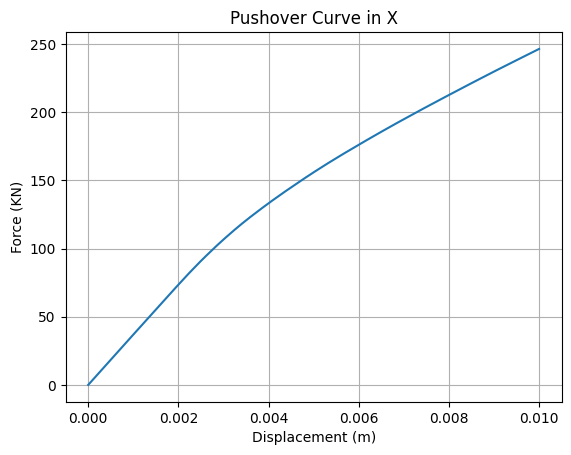

In [16]:
df1=reader('3ModalAnalysis_Pushover_Horizontal_ReactionsX.txt')
df2=reader('3ModalAnalysis_Pushover_Storey_DisplacementX.txt')
df1.columns=['Time','Rxa','Rxb','Rxc','Rxd']
df2.columns=['Time','Dispxa','Dispxb','Dispxc','Dispxd']
# df2
df=pd.merge(df1,df2)
df['Force']=-1*(df['Rxa']+df['Rxb']+df['Rxc']+df['Rxd'])
df['Displacement']=0.25*(df['Dispxa']+df['Dispxb']+df['Dispxc']+df['Dispxd'])
print(df)

#the last argument is the point in the graph to zoom. first element is xlower,second xupper, third ylower, fourth yupper
# plotter(df['Displacement'],df['Force'],'Pushover in X','Displacement(m)','Force (KN)',True,[0.04,0.06,550,580])

plt.plot(df['Displacement'],df['Force'])
plt.title('Pushover Curve in X')
plt.xlabel('Displacement (m)')
plt.grid()
plt.ylabel('Force (KN)')
plt.show()

# scatterplot(range(1,1+len(df['Displacement'])),df['Displacement'])
# plotter(range(1,1+len(df['Displacement'])),df['Displacement'],'displacement step vs displacement for debug','displacement step','displacement',False,[])
# plotter(range(1,1+len(df['Force'])),df['Force'],'step vs force for debug','disp step','force',False,[])
